In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import string
import re
import warnings
warnings.filterwarnings("ignore")
import spacy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **MLP Model**

In [3]:
data = pd.read_csv("/content/data/final_filtered_annotated_reviews.csv")

In [4]:
data.shape

(13594, 2)

In [5]:
data.columns

Index(['the_review', 'topics'], dtype='object')

In [6]:
data.head()

,the_review,topics
0,I wish I would have gotten one earlier. I love...,mouse
1,It is so slow and lags find a better option,mouse
2,Beautifully produced and lovely to look at for...,mouse
3,I don't typically write reviews but I keep hav...,mouse
4,"I bought this in late June, it looks cool with...",mouse


In [7]:
data.head()

,the_review,topics
0,I wish I would have gotten one earlier. I love...,mouse
1,It is so slow and lags find a better option,mouse
2,Beautifully produced and lovely to look at for...,mouse
3,I don't typically write reviews but I keep hav...,mouse
4,"I bought this in late June, it looks cool with...",mouse


### **Data Preprocessing**

In [ ]:
def preprocess(sent):
    '''Cleans text data up, leaving only 2 or
        more char long non-stopwords composed of A-Z & a-z only
        in lowercase'''
    # lowercase
    sentence = sent.lower()

    # Remove RT
    sentence = re.sub('RT @\w+: '," ",sentence)

    # Remove special characters
    sentence = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", sentence)

    # Removing digits
    sentence = sentence.translate(str.maketrans('', '', string.digits))

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence) 
    # When we remove apostrophe from the word "Mark's", 
    # the apostrophe is replaced by an empty space. 
    # Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  
    # Next, we remove all the single characters and replace it by a space 
    # which creates multiple spaces in our text. 
    # Finally, we remove the multiple spaces from our text as well.

    return sentence


In [9]:
text_cleaned = data.copy()
text_cleaned['cleaned_review'] = text_cleaned.the_review.apply(preprocess)

In [10]:
columns_needed = [
    "cleaned_review",
    "topics"
]

In [11]:
model_data = text_cleaned[columns_needed]

In [12]:
model_data.sample(2,random_state=42)

,cleaned_review,topics
1061,it is nice mouse and liked that it came with a...,mouse
3881,worth it,headphone


In [13]:
topics = model_data.topics.unique().tolist()
topics_mappings = {}
for index,value in enumerate(topics):
    topics_mappings[value]=index
topics_mappings

{'mouse': 0, 'headphone': 1, 'keyboard_speakers': 2}

In [14]:
model_data['topic_label'] = model_data.topics.map(topics_mappings)

In [15]:
model_data.head()

,cleaned_review,topics,topic_label
0,i wish would have gotten one earlier love it a...,mouse,0
1,it is so slow and lags find better option,mouse,0
2,beautifully produced and lovely to look at for...,mouse,0
3,i don typically write reviews but keep having ...,mouse,0
4,i bought this in late june it looks cool with ...,mouse,0


### **Model Training & Metrics**

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
# from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix,\
ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as Pipeline

In [17]:
# https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html
# https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.Pipeline.html

In [18]:
model_data.head()

,cleaned_review,topics,topic_label
0,i wish would have gotten one earlier love it a...,mouse,0
1,it is so slow and lags find better option,mouse,0
2,beautifully produced and lovely to look at for...,mouse,0
3,i don typically write reviews but keep having ...,mouse,0
4,i bought this in late june it looks cool with ...,mouse,0


In [20]:
X = model_data.iloc[:,0]
y = model_data.iloc[:,-1]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    random_state=42,
                                                    stratify=y)

In [23]:
my_pipeline = Pipeline([
    ("vectorizer",TfidfVectorizer(stop_words='english',ngram_range=(2,3))),
    ("under_sampler",RandomUnderSampler(random_state=42)),
    ("classifier",MLPClassifier(random_state=42))
    ]
)

In [24]:
my_pipeline

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(2, 3), stop_words='english')),
                ('under_sampler', RandomUnderSampler(random_state=42)),
                ('classifier', MLPClassifier(random_state=42))])

In [25]:
import time
start = time.time()
my_pipeline.fit(X_train,y_train)
end = time.time()
print(f" Training time: {end-start} in seconds")

 Training time: 1854.1085970401764 in seconds


In [26]:
full_seconds = end - start
def convert_from_seconds(seconds):
  hours = int(seconds // 3600)
  minutes = int((seconds % 3600) // 60)
  seconds = int(seconds % 60)
  print(f"{hours} hours {minutes} minutes {seconds} seconds")
convert_from_seconds(full_seconds)

0 hours 30 minutes 54 seconds


In [32]:
# Confirming the samples
sampler = my_pipeline.named_steps['under_sampler']
print(f"Sampling Strategy used: {sampler.sampling_strategy_}")
print(f"Number of samples in resampled data: {sampler.sample_indices_.shape}")

Sampling Strategy used: OrderedDict({np.int64(0): np.int64(2988), np.int64(1): np.int64(2988)})
Number of samples in resampled data: (8964,)


In [44]:
resampled_indices = sampler.sample_indices_
print(resampled_indices.shape)
print(resampled_indices)

(8964,)
[   0    1    2 ... 6699 6264 6906]


In [27]:
y_pred_train = my_pipeline.predict(X_train)

In [38]:
# Getting the resampled data
y_train_resampled = y_train.iloc[resampled_indices]
y_pred_train_resampled = y_pred_train[resampled_indices]

In [39]:
# Classification report train data
sns.set_theme(style="white")
def class_report_train(model_name,model,y_train_resampled,y_pred_train_resampled):
    print(classification_report(y_train_resampled,y_pred_train_resampled))
    cm = confusion_matrix(y_train_resampled,y_pred_train_resampled)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.named_steps['classifier'].classes_)
    disp.plot()
    plt.savefig(f"/content/img/train_set_confusion_matrix_{model_name}")
    plt.show()

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      2988
           1       0.95      1.00      0.97      2988
           2       1.00      0.98      0.99      2988

    accuracy                           0.98      8964
   macro avg       0.98      0.98      0.98      8964
weighted avg       0.98      0.98      0.98      8964



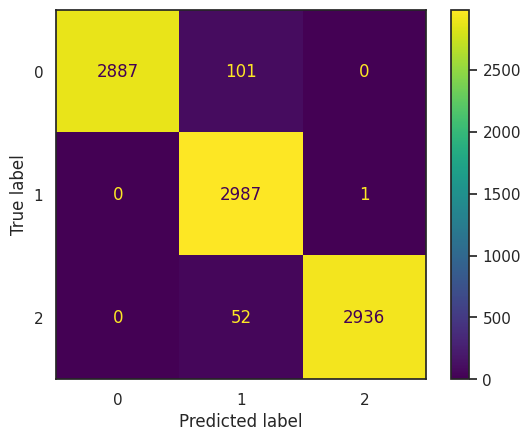

In [41]:
class_report_train('mlp',my_pipeline,y_train_resampled,y_pred_train_resampled)

In [ ]:
# https://www.scikit-yb.org/en/latest/api/classifier/rocauc.html?highlight=roc#yellowbrick.classifier.rocauc.ROCAUC

### **Plotting the ROCAUC Curve**

(8964,)
(8964,)


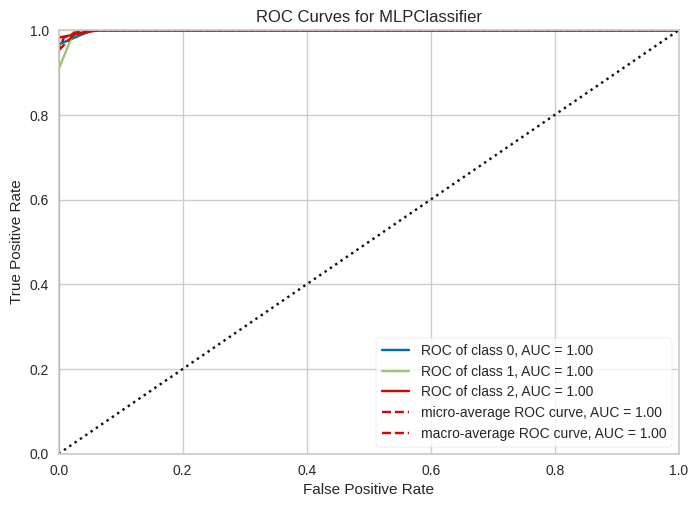

<Axes: title={'center': 'ROC Curves for MLPClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [43]:
from yellowbrick.classifier import ROCAUC

# Resampled X_train and y_train
X_train_resampled = X_train.iloc[resampled_indices]
y_train_resampled = y_train.iloc[resampled_indices]

print(X_train_resampled.shape)
print(y_train_resampled.shape)

# Plotting the curve
visualiser_train = ROCAUC(my_pipeline, classes=[0,1,2])

visualiser_train.fit(X_train_resampled, y_train_resampled) # Fit the training data to the visualiser
visualiser_train.score(X_train_resampled, y_train_resampled) # Evaluate the model on the train data
visualiser_train.show() # Finalise and show the figure

{'mouse': 0, 'headphone': 1, 'keyboard_speakers': 2}

### **Model Test & Metrics**

In [57]:
y_pred = my_pipeline.predict(X_test)

In [58]:
# Classification report test data
sns.set_theme(style="white")
def class_report_test(model_name,model,y_test,y_pred):
    print(classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test,y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
    disp.plot()
    plt.savefig(f"/content/img/test_set_confusion_matrix_{model_name}")
    plt.show()

              precision    recall  f1-score   support

           0       0.98      0.55      0.71      1093
           1       0.64      0.87      0.74       879
           2       0.62      0.76      0.68       747

    accuracy                           0.71      2719
   macro avg       0.75      0.73      0.71      2719
weighted avg       0.77      0.71      0.71      2719



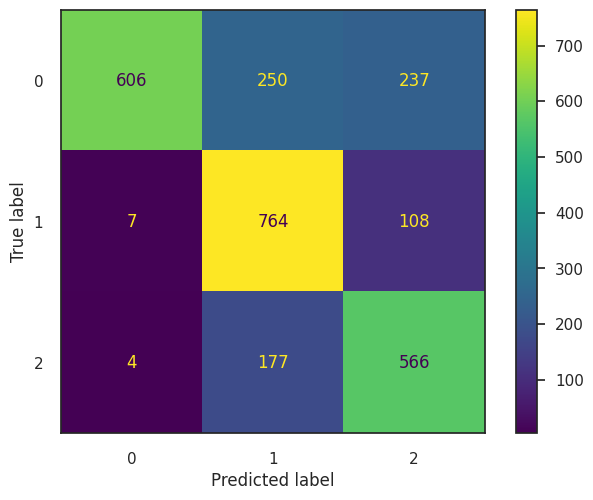

In [59]:
class_report_test("mlp",my_pipeline,y_test,y_pred)

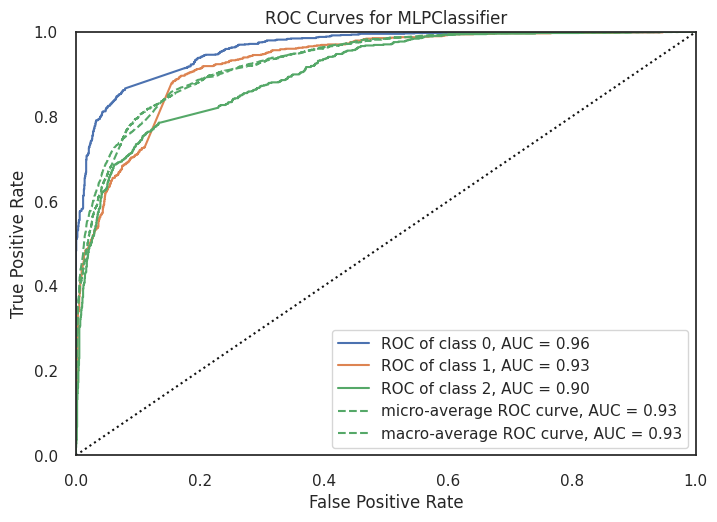

<Axes: title={'center': 'ROC Curves for MLPClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [60]:
from yellowbrick.classifier import ROCAUC
visualiser_test = ROCAUC(my_pipeline, classes=[0,1,2])

visualiser_test.fit(X_train, y_train) # Fit the training data to the visualiser
visualiser_test.score(X_test, y_test) # Evaluate the model on the test data
visualiser_test.show() # Finalise and show the figure